<h1 align="center"> Modern methods of data analysis

## <font color="green"> Homework 1 </font>: Clustering problem

### Work has been done by: Ryabykin Aleksey
---

<a name = 'content'></a>
<h1 align="center">Table of Contents

#### [Task 1. Image Clustering](#step1)
 * ##### [Data preparation](#step1.1)
 * ##### [kMeans clustering using just colors](#step1.2)
 * ##### [kMeans clustering using color and pixel positions information](#step1.3)

#### [Task 2. Determine the optimal number of clusters](#step2)
 * ##### [Data preparation](#step2.1)
 * ##### [kMeans clustering](#step2.2)
   * ##### Elbow method
   * ##### Silhouette score
   * ##### Calinski Harabasz

#### [Task 3. Hierarchical clustering](#step3)
 * ##### [Data preparation](#step3.1)
 * ##### [Clustering (objects)](#step3.2)
 * ##### [Clustering (features)](#step3.3) 

In [91]:
from imageio.v2 import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
# from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
import seaborn as sns
import plotly 
import os
from sklearn.preprocessing import StandardScaler
import random

In [32]:
DATA_PATH = "./data/"
IMAGES_PATH = os.path.join(DATA_PATH, "images/")
COMPRESSED_IMAGES_PATH = os.path.join(IMAGES_PATH, "compressed/")
IMAGES = [os.path.join(IMAGES_PATH, image) for image in os.listdir(IMAGES_PATH)[1:]]
ELBOW_PATH = os.path.join(DATA_PATH, "elbow.txt")
NUTRIENT_PATH = os.path.join(DATA_PATH, "nutrient.dat")
SEED = 0xDEAD + 0xDEAD

<a name="step1"></a>

### Task 1. Image Clustering

[To the ToC](#content)

<a name="step1.1"> </a>

#### Data preparation

Let's choose 4 photos to work with. Firstly lets do clustering just by colors information.

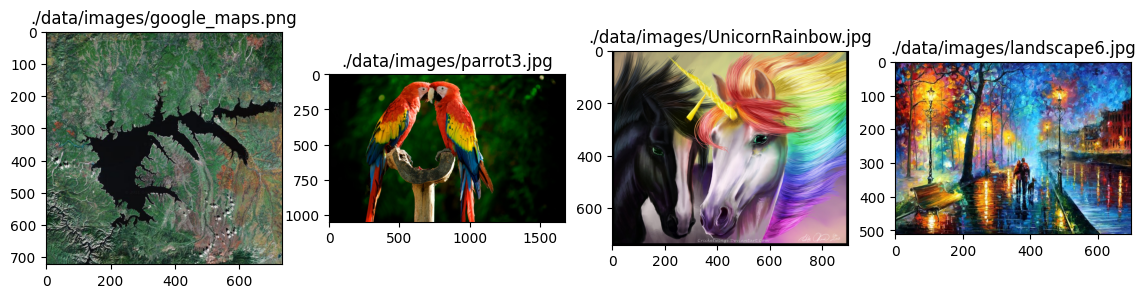

In [38]:
random.seed(SEED)
np.random.seed(SEED)
n_img = 4
indexes = random.sample(range(len(IMAGES) - 1), k=n_img)
fig, ax = plt.subplots(1, n_img, figsize=(14, 10))
imgs = []
for i, index in enumerate(indexes):
    pic = IMAGES[index]
    imgs.append({"image": imread(pic), "path": pic})
    imgs[-1]['rows'], imgs[-1]['cols'] = imgs[-1]['image'].shape[:2]
    imgs[-1]['size'] = os.path.getsize(pic)
    ax[i].imshow(imgs[-1]['image'])
    ax[i].set_title(pic)

In [101]:
def get_features(img: np.ndarray, use_pos: bool=False) -> np.ndarray:
    '''
    It takes an original image, add to it pixel positions and after all reshape it in feature table or
    just make the last one action. It depence on ``use_pos`` boolean value.
    '''
    return np.dstack(
        (np.indices(img.shape[:2]).transpose(1, 2, 0),
        img)).reshape(-1, 5) if use_pos else img.reshape(-1, 3)

<a name="step1.2"> </a>

#### kMeans clustering using just colors

In [131]:
def get_compressed_image(data: dict, n_clusters: int=4, use_pos: bool=False) -> np.ndarray:
    '''
    It takes features 
    '''
    if use_pos == False:
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(data["features"])
        compressed_image = kmeans.cluster_centers_[kmeans.predict(data["features"])]
    else:
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(StandardScaler().fit_transform(data["features"]))
        df = pd.DataFrame(data["features"], columns=['pos1', 'pos2', 'red', 'green', 'blue'])
        df['target'] = kmeans.labels_
        df['r'] = df.groupby('target')['red'].transform("mean")
        df['g'] = df.groupby('target')['green'].transform("mean")
        df['b'] = df.groupby('target')['blue'].transform("mean")
        compressed_image = df[['r', 'g', 'b']].values
    compressed_image = compressed_image.reshape((data["rows"], data["cols"], 3)).astype('uint8')
    compressed_path = "compressed_" + os.path.basename(data["path"])
    plt.imsave(os.path.join(COMPRESSED_IMAGES_PATH, compressed_path), compressed_image)
    data["compressed_file"] = os.path.join(COMPRESSED_IMAGES_PATH, compressed_path)
    return compressed_image

In [132]:
for img in imgs:
    img['features'] = get_features(img["image"])

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


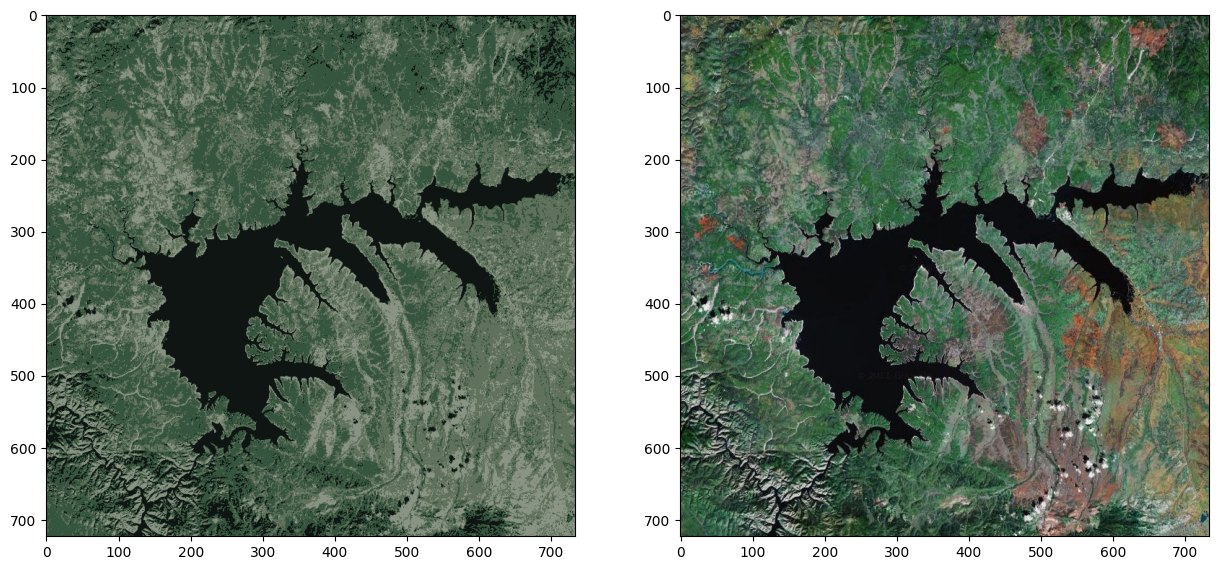

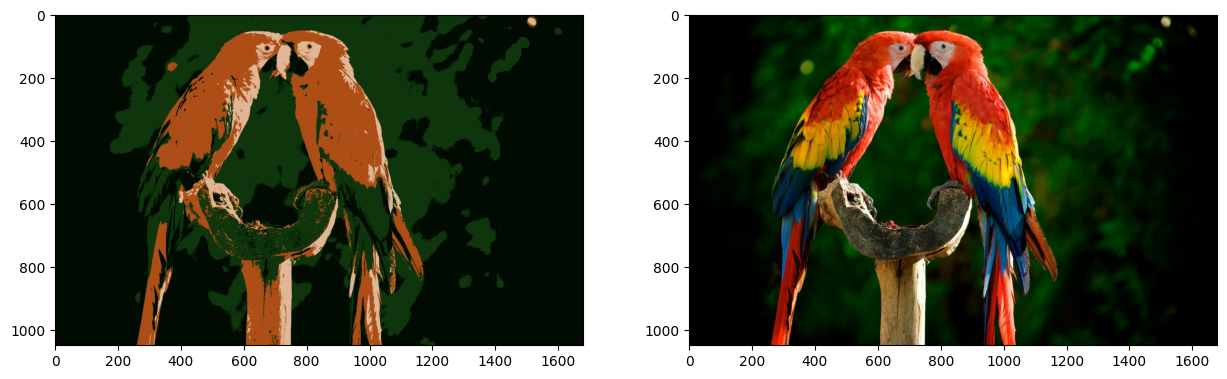

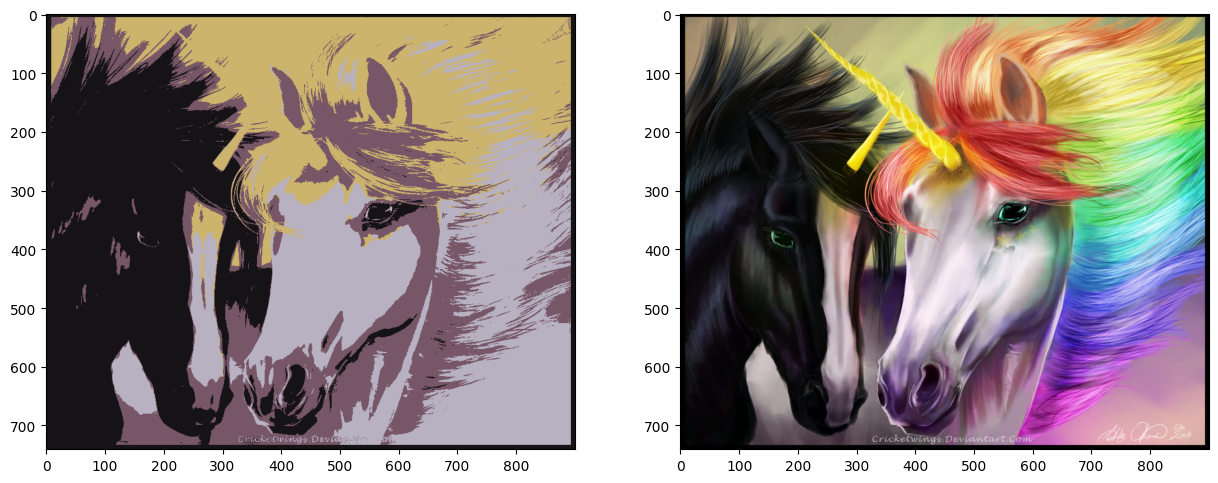

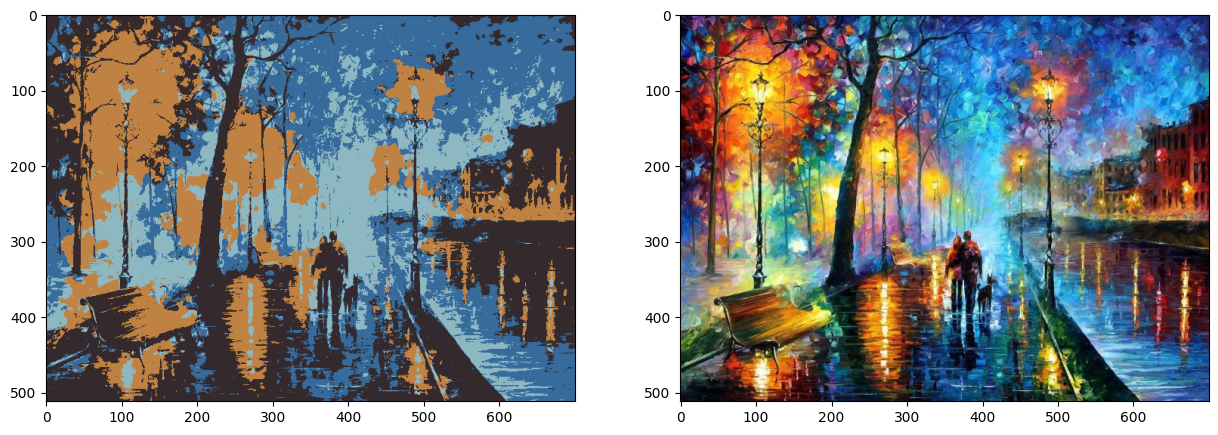

In [133]:
for img in tqdm(imgs):
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0].imshow(get_compressed_image(img))
    ax[1].imshow(img['image'])

Take one image and variate number of clusters from 4 to 16

100%|██████████| 8/8 [00:41<00:00,  5.15s/it]


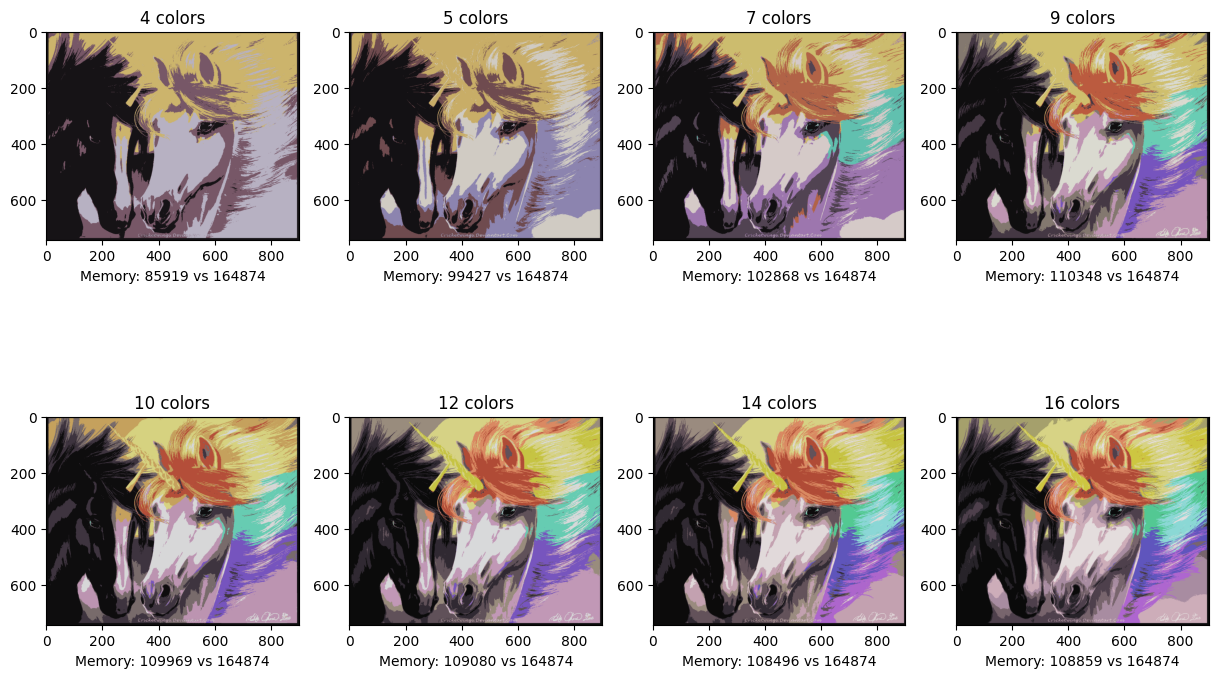

In [134]:
image_data = imgs[2]
clusters_count = np.linspace(4, 16, 8, dtype=int)
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
for i, n_clusters in enumerate(tqdm(clusters_count)):
    ax[i // 4][i % 4].imshow(get_compressed_image(image_data, n_clusters))
    ax[i // 4][i % 4].set_title(str(n_clusters) + " colors")
    ax[i // 4][i % 4].set_xlabel("Memory: " + str(os.path.getsize(
        image_data["compressed_file"])) + " vs "
        + str(os.path.getsize(image_data["path"])))
plt.subplots_adjust(hspace=0)
plt.show()

<a name="step1.3"></a>
#### kMeans using also a pixel coordinates information

Now lets use information about pixel position.

In [135]:
for img in tqdm(imgs):
    img['features'] = get_features(img["image"], use_pos=True)

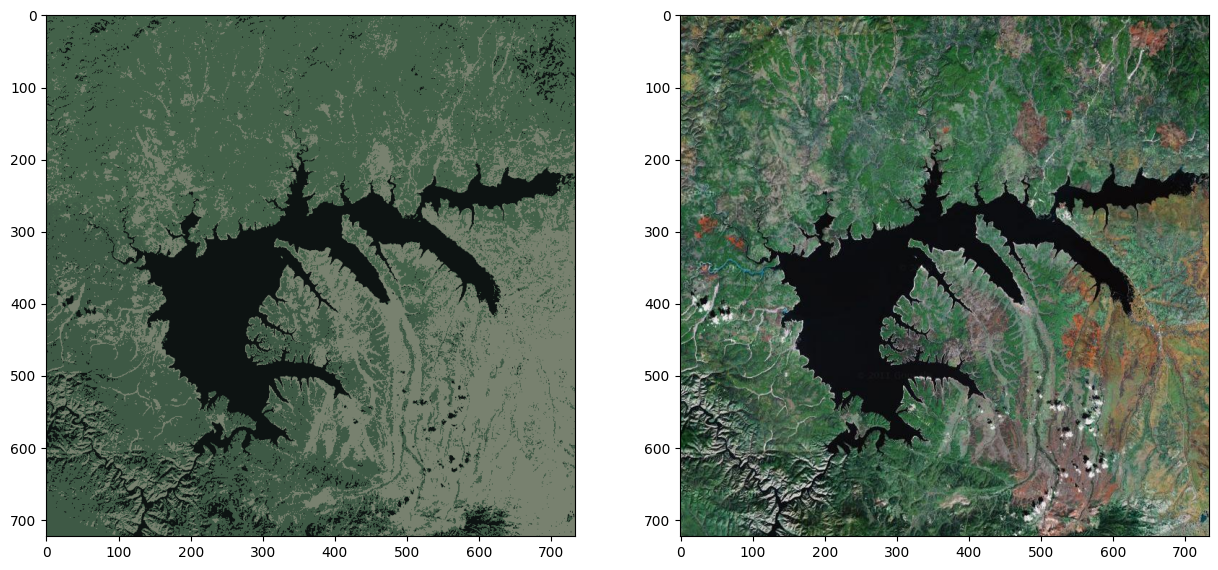

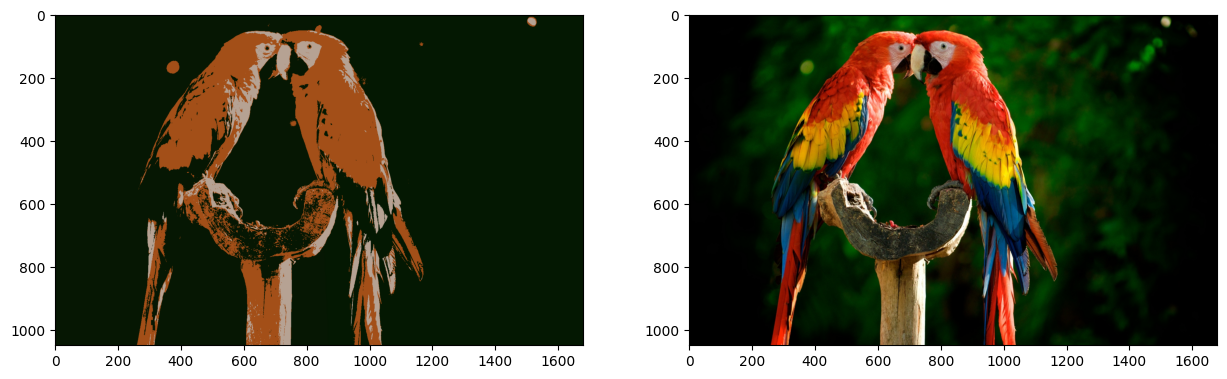

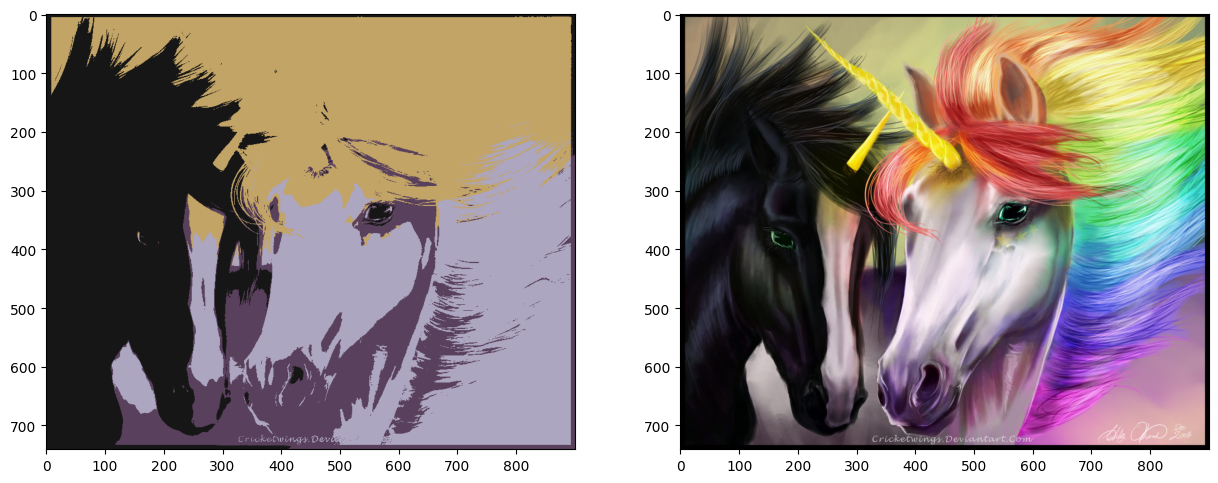

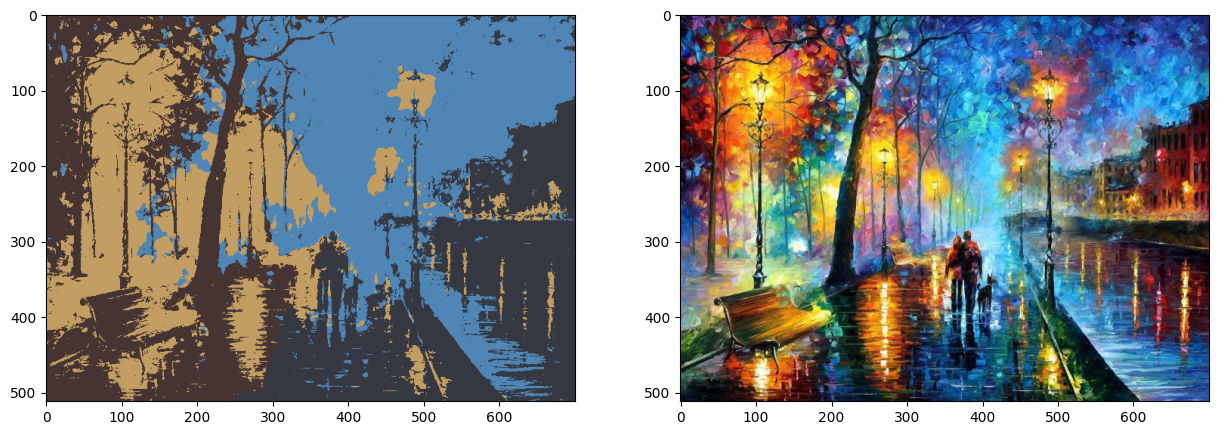

In [136]:
for img in tqdm(imgs):
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0].imshow(get_compressed_image(img, use_pos=True))
    ax[1].imshow(img['image'])

100%|██████████| 8/8 [00:42<00:00,  5.31s/it]


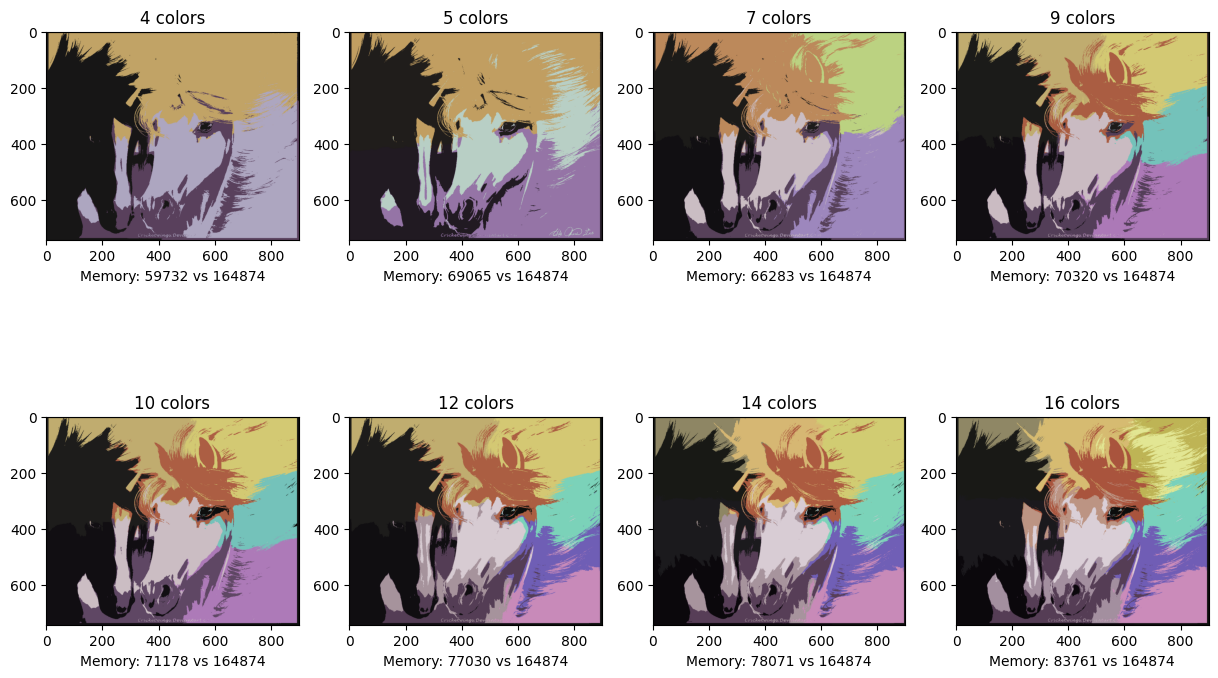

In [137]:
image_data = imgs[2]
clusters_count = np.linspace(4, 16, 8, dtype=int)
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
for i, n_clusters in enumerate(tqdm(clusters_count)):
    ax[i // 4][i % 4].imshow(get_compressed_image(image_data, n_clusters, use_pos=True))
    ax[i // 4][i % 4].set_title(str(n_clusters) + " colors")
    ax[i // 4][i % 4].set_xlabel("Memory: " + str(os.path.getsize(
        image_data["compressed_file"])) + " vs "
        + str(os.path.getsize(image_data["path"])))
plt.subplots_adjust(hspace=0)
plt.show()

<a name="step2"> </a>

## Task 2. Determine the optimal number of clusters

[To the ToC](#content)

In [162]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

<a name="step2.1"> </a>

#### Data preparation

In [144]:
elbow_data = pd.read_csv(ELBOW_PATH, delimiter='\t', header=None, decimal=',')
features = StandardScaler().fit_transform(elbow_data.values)
elbow_data.sample(5)

0         1
473  1.674052 -2.603798
302 -4.060142 -1.684733
185  2.410258  0.771359
5   -2.740908  3.478782
77  -1.488695  3.411948

<a name="step2.2"> </a>

#### kMeans clustering

Inetria scores

In [149]:
n_clusters_list = range(1, 10)
inertia_scores = []
for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters).fit(features)
    inertia_scores.append(kmeans.inertia_)

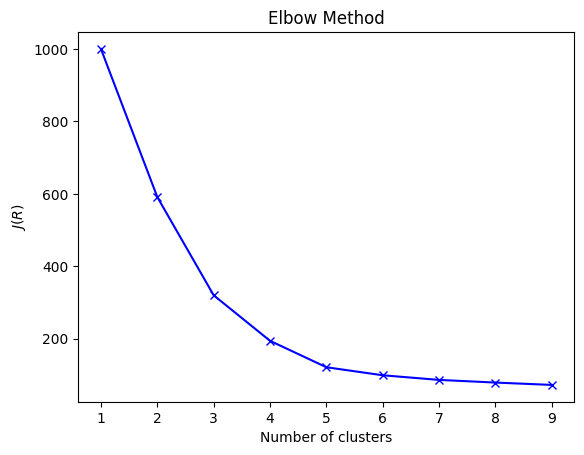

In [165]:
plt.plot(n_clusters_list, inertia_scores, 'bx-')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("$J(R)$");

The optimal number of clusters is ``4``.

Silhouette scores

In [167]:
silhouette_scores = []
for n_clusters in n_clusters_list[1:]:
    labels = KMeans(n_clusters=n_clusters).fit_predict(features)
    silhouette_scores.append(silhouette_score(features, labels))

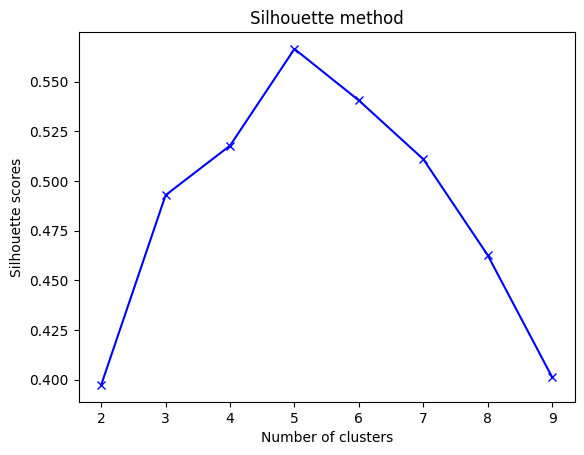

In [168]:
plt.plot(n_clusters_list[1:], silhouette_scores, 'bx-')
plt.title("Silhouette method")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette scores");

From Silhouette method we can obtain that ``5`` is the optimal number of clusters.

Calinski Harabasz score

In [169]:
calinski_harabasz_scores = []
for n_clusters in n_clusters_list[1:]:
    labels = KMeans(n_clusters=n_clusters).fit_predict(features)
    calinski_harabasz_scores.append(calinski_harabasz_score(features, labels))

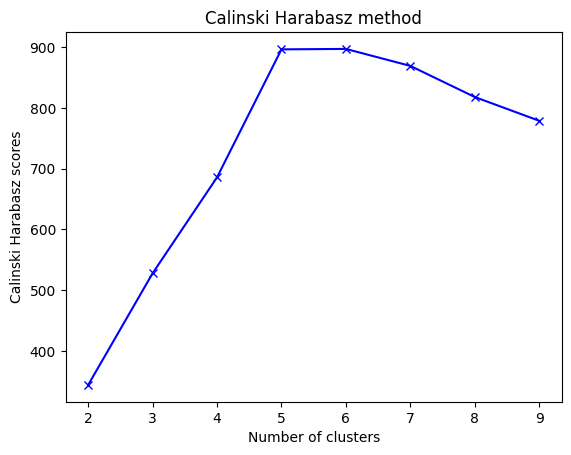

In [170]:
plt.plot(n_clusters_list[1:], calinski_harabasz_scores, 'bx-')
plt.title("Calinski Harabasz method")
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz scores");

It follows from the graph that optimal number of clusters is equal to ``5``. It coincides with silhouette method, but does not satisfy the Elbow one.

<a name="step3"></a>

### Task 3. Hierarchical clustering

[To the ToC](#content)

In [183]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

<a name="step3.1"> </a>

#### Data preparation

In [172]:
df = pd.read_csv(NUTRIENT_PATH, delimiter="\s+ ", header=None)
df.sample(3)

C:\Users\Aleksey\AppData\Local\Temp\ipykernel_30636\4286432312.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(NUTRIENT_PATH, delimiter="\s+ ", header=None)


0    1   2   3    4    5
11     PORK ROAST  340  19  29    9  2.5
23  SALMON CANNED  120  17   5  159  0.7
25    TUNA CANNED  170  25   7    7  1.2

In [175]:
df.columns = ['food name', "cals", "protein", "fats", "calcium", "iron"]
df.sample(3)

food name  cals  protein  fats  calcium  iron
0      BEEF BRAISED   340       20    28        9   2.6
4       BEEF CANNED   180       22    10       17   3.7
24  SARDINES CANNED   180       22     9      367   2.5

In [214]:
data = StandardScaler().fit_transform(df[df.columns[1:]].values)

<a name="step3.2"> </a>

#### Clustering (objects)

In [215]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

Single linkage

In [216]:
Z = linkage(data, method='single', metric='euclidean')

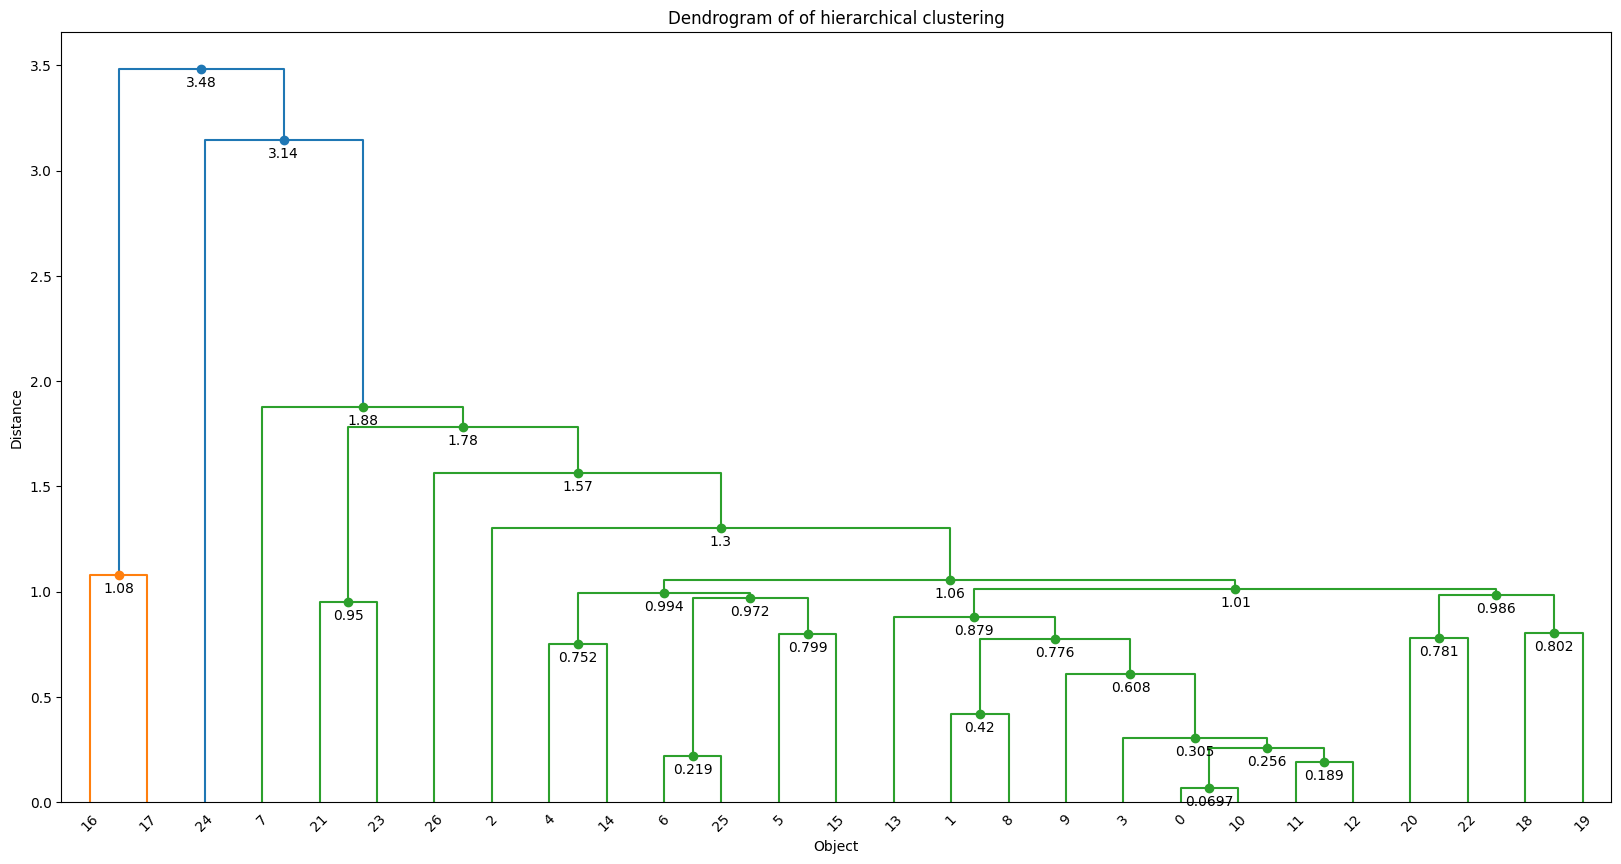

In [217]:
plt.figure(figsize=(20,10))
fancy_dendrogram(Z, 
    show_contracted=True);
plt.title("Dendrogram of of hierarchical clustering")
plt.xlabel("Object")
plt.ylabel("Distance")
plt.show()

In [228]:
df['cluster'] = fcluster(Z, t=1.57, criterion='distance')
df.sort_values('cluster')

food name  cals  protein  fats  calcium  iron  cluster
17         CLAMS CANNED    45        7     1       74   5.4        1
16            CLAMS RAW    70       11     1       82   6.0        1
23        SALMON CANNED   120       17     5      159   0.7        2
21      MACKEREL CANNED   155       16     9      157   1.8        2
0          BEEF BRAISED   340       20    28        9   2.6        3
22          PERCH FRIED   195       16    11       14   1.3        3
20     MACKEREL BROILED   200       19    13        5   1.0        3
19        HADDOCK FRIED   135       16     5       15   0.5        3
18      CRABMEAT CANNED    90       14     2       38   0.8        3
15       BLUEFISH BAKED   135       22     4       25   0.6        3
14          VEAL CUTLET   185       23     9        9   2.7        3
25          TUNA CANNED   170       25     7        7   1.2        3
13          BEEF TONGUE   205       18    14        7   2.5        3
11           PORK ROAST   340       19    29        9   2.5        3
10           SMOKED HAM   340       20    28        9   2.5        3
9   LAMB SHOULDER ROAST   300       18    25        9   2.3        3
8        LAMB LEG ROAST   265       20    20        9   2.6        3
6        CHICKEN CANNED   170       25     7       12   1.5        3
5       CHICKEN BROILED   115       20     3        8   1.4        3
4           BEEF CANNED   180       22    10       17   3.7        3
3            BEEF STEAK   375       19    32        9   2.6        3
2            BEEF ROAST   420       15    39        7   2.0        3
1             HAMBURGER   245       21    17        9   2.7        3
12        PORK SIMMERED   355       19    30        9   2.4        3
26        SHRIMP CANNED   110       23     1       98   2.6        3
7            BEEF HEART   160       26     5       14   5.9        4
24      SARDINES CANNED   180       22     9      367   2.5        5

1. The first cluster determines low-calorie food includes not so much protein and fats. 
2. The second one shows calcium-rich food that contains not so much value of iron. It is canned seafood.
3. The third cluster is the biggest one. Contains a lot of nutrients and not so few calories.

Last two clusters consist of food, that contain maximum value of iron and calcium respectively.

Complete linkage

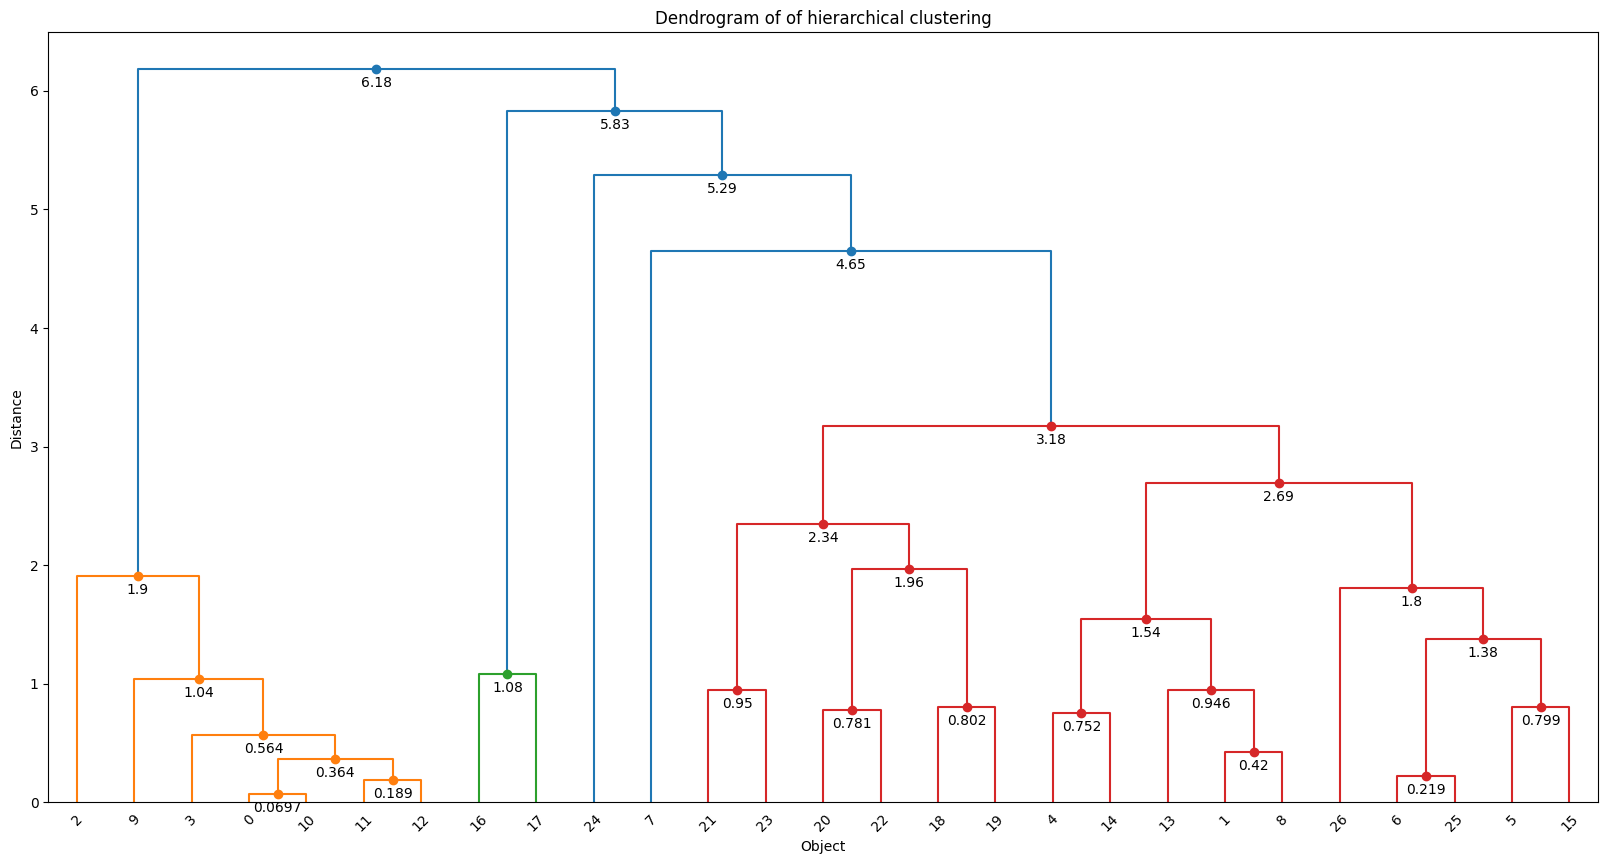

In [231]:
Z = linkage(data, method='complete', metric='euclidean')
plt.figure(figsize=(20,10))
fancy_dendrogram(Z, 
    show_contracted=True);
plt.title("Dendrogram of of hierarchical clustering")
plt.xlabel("Object")
plt.ylabel("Distance")
plt.show()

In [233]:
df['cluster'] = fcluster(Z, t=3.18, criterion='distance')
df.sort_values('cluster')

food name  cals  protein  fats  calcium  iron  cluster
0          BEEF BRAISED   340       20    28        9   2.6        1
2            BEEF ROAST   420       15    39        7   2.0        1
3            BEEF STEAK   375       19    32        9   2.6        1
9   LAMB SHOULDER ROAST   300       18    25        9   2.3        1
10           SMOKED HAM   340       20    28        9   2.5        1
11           PORK ROAST   340       19    29        9   2.5        1
12        PORK SIMMERED   355       19    30        9   2.4        1
17         CLAMS CANNED    45        7     1       74   5.4        2
16            CLAMS RAW    70       11     1       82   6.0        2
23        SALMON CANNED   120       17     5      159   0.7        3
22          PERCH FRIED   195       16    11       14   1.3        3
21      MACKEREL CANNED   155       16     9      157   1.8        3
20     MACKEREL BROILED   200       19    13        5   1.0        3
19        HADDOCK FRIED   135       16     5       15   0.5        3
18      CRABMEAT CANNED    90       14     2       38   0.8        3
13          BEEF TONGUE   205       18    14        7   2.5        3
14          VEAL CUTLET   185       23     9        9   2.7        3
25          TUNA CANNED   170       25     7        7   1.2        3
8        LAMB LEG ROAST   265       20    20        9   2.6        3
6        CHICKEN CANNED   170       25     7       12   1.5        3
5       CHICKEN BROILED   115       20     3        8   1.4        3
4           BEEF CANNED   180       22    10       17   3.7        3
1             HAMBURGER   245       21    17        9   2.7        3
15       BLUEFISH BAKED   135       22     4       25   0.6        3
26        SHRIMP CANNED   110       23     1       98   2.6        3
7            BEEF HEART   160       26     5       14   5.9        4
24      SARDINES CANNED   180       22     9      367   2.5        5

1. Fried, high-calorie food are contained in the first cluster.
2. The same as the first cluster of the single linkage.
3. The biggest cluster with mean value of calories, a lot of nutrients and proteind; and not so much fats.

Last two clusters same for single linkage.

Average linkage

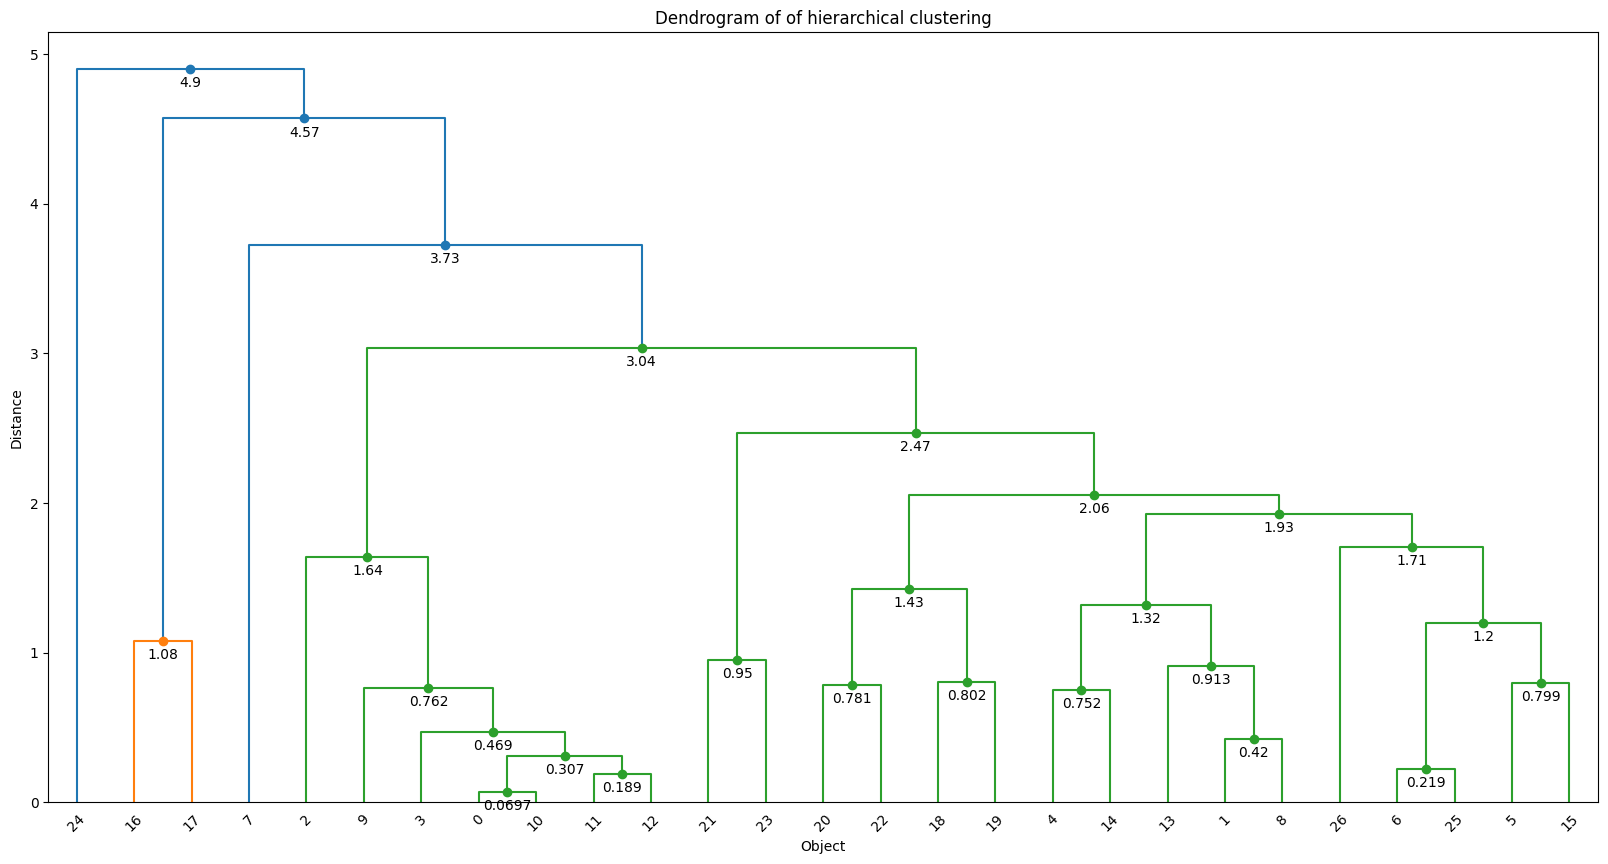

In [234]:
Z = linkage(data, method='average', metric='euclidean')
plt.figure(figsize=(20,10))
fancy_dendrogram(Z, 
    show_contracted=True);
plt.title("Dendrogram of of hierarchical clustering")
plt.xlabel("Object")
plt.ylabel("Distance")
plt.show()

In [235]:
df['cluster'] = fcluster(Z, t=2.47, criterion='distance')
df.sort_values('cluster')

food name  cals  protein  fats  calcium  iron  cluster
17         CLAMS CANNED    45        7     1       74   5.4        1
16            CLAMS RAW    70       11     1       82   6.0        1
0          BEEF BRAISED   340       20    28        9   2.6        2
2            BEEF ROAST   420       15    39        7   2.0        2
3            BEEF STEAK   375       19    32        9   2.6        2
9   LAMB SHOULDER ROAST   300       18    25        9   2.3        2
10           SMOKED HAM   340       20    28        9   2.5        2
11           PORK ROAST   340       19    29        9   2.5        2
12        PORK SIMMERED   355       19    30        9   2.4        2
23        SALMON CANNED   120       17     5      159   0.7        3
22          PERCH FRIED   195       16    11       14   1.3        3
21      MACKEREL CANNED   155       16     9      157   1.8        3
20     MACKEREL BROILED   200       19    13        5   1.0        3
19        HADDOCK FRIED   135       16     5       15   0.5        3
18      CRABMEAT CANNED    90       14     2       38   0.8        3
13          BEEF TONGUE   205       18    14        7   2.5        3
14          VEAL CUTLET   185       23     9        9   2.7        3
25          TUNA CANNED   170       25     7        7   1.2        3
8        LAMB LEG ROAST   265       20    20        9   2.6        3
6        CHICKEN CANNED   170       25     7       12   1.5        3
5       CHICKEN BROILED   115       20     3        8   1.4        3
4           BEEF CANNED   180       22    10       17   3.7        3
1             HAMBURGER   245       21    17        9   2.7        3
15       BLUEFISH BAKED   135       22     4       25   0.6        3
26        SHRIMP CANNED   110       23     1       98   2.6        3
7            BEEF HEART   160       26     5       14   5.9        4
24      SARDINES CANNED   180       22     9      367   2.5        5

Results that are comparable with the complete linkage.

Last two clusters are the same as for the previous methods.

<a name="step3.3"></a>

#### Clustering (features)

In [249]:
df = df.drop(columns=['cluster'])

In [250]:
features = pd.DataFrame(df[df.columns[1:]].values.T)

In [251]:
features['name'] = df.columns[1:]

In [252]:
data = StandardScaler().fit_transform(features[features.columns[:-1]].values)

Single linkage

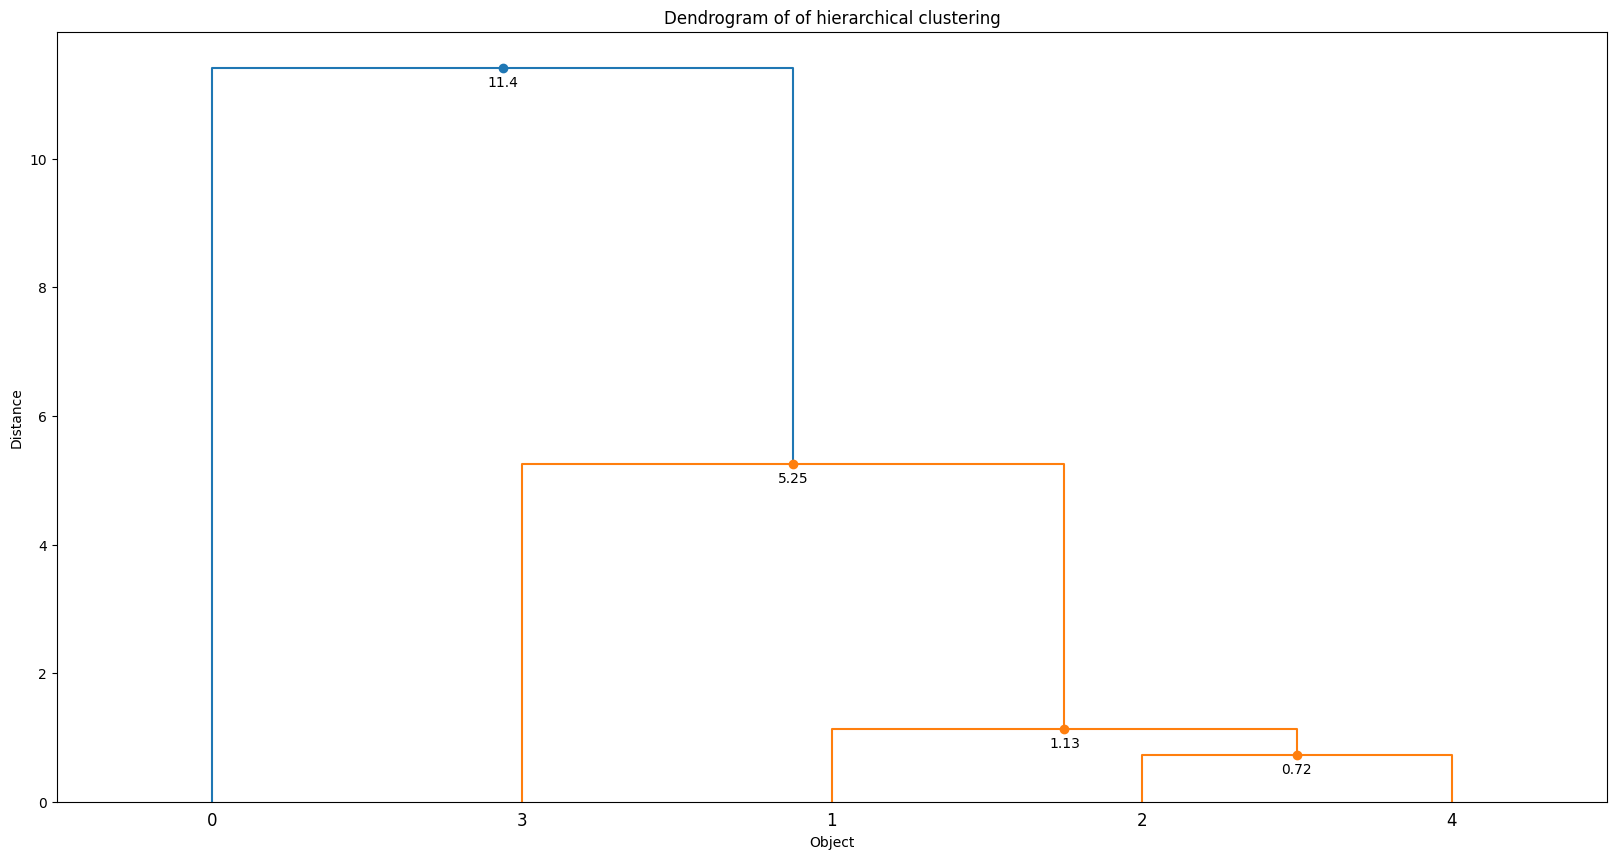

In [253]:
Z = linkage(data, method='single', metric='euclidean')
plt.figure(figsize=(20,10))
fancy_dendrogram(Z, 
    show_contracted=True);
plt.title("Dendrogram of of hierarchical clustering")
plt.xlabel("Object")
plt.ylabel("Distance")
plt.show()

In [259]:
features['cluster'] = fcluster(Z, t=5, criterion='distance')
features.sort_values('cluster')

0      1      2      3      4      5      6      7      8      9  ...  \
1   20.0   21.0   15.0   19.0   22.0   20.0   25.0   26.0   20.0   18.0  ...   
2   28.0   17.0   39.0   32.0   10.0    3.0    7.0    5.0   20.0   25.0  ...   
4    2.6    2.7    2.0    2.6    3.7    1.4    1.5    5.9    2.6    2.3  ...   
3    9.0    9.0    7.0    9.0   17.0    8.0   12.0   14.0    9.0    9.0  ...   
0  340.0  245.0  420.0  375.0  180.0  115.0  170.0  160.0  265.0  300.0  ...   

      19     20     21     22     23     24     25     26     name  cluster  
1   16.0   19.0   16.0   16.0   17.0   22.0   25.0   23.0  protein        1  
2    5.0   13.0    9.0   11.0    5.0    9.0    7.0    1.0     fats        1  
4    0.5    1.0    1.8    1.3    0.7    2.5    1.2    2.6     iron        1  
3   15.0    5.0  157.0   14.0  159.0  367.0    7.0   98.0  calcium        2  
0  135.0  200.0  155.0  195.0  120.0  180.0  170.0  110.0     cals        3  

[5 rows x 29 columns]

Complete linkage

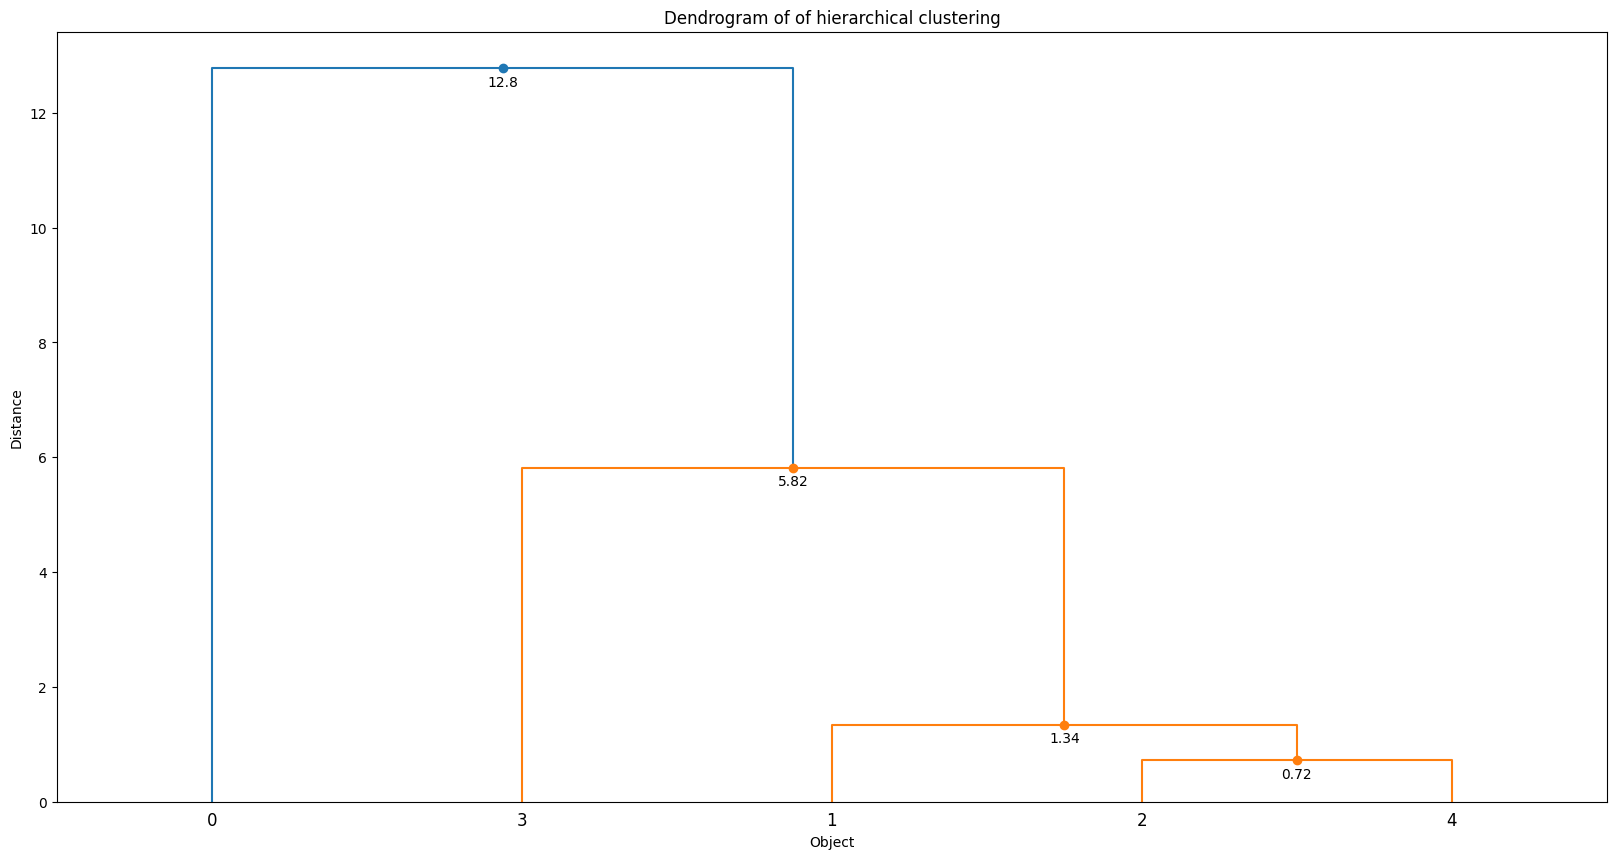

In [260]:
Z = linkage(data, method='complete', metric='euclidean')
plt.figure(figsize=(20,10))
fancy_dendrogram(Z, 
    show_contracted=True);
plt.title("Dendrogram of of hierarchical clustering")
plt.xlabel("Object")
plt.ylabel("Distance")
plt.show()

In [261]:
features['cluster'] = fcluster(Z, t=5, criterion='distance')
features.sort_values('cluster')

0      1      2      3      4      5      6      7      8      9  ...  \
1   20.0   21.0   15.0   19.0   22.0   20.0   25.0   26.0   20.0   18.0  ...   
2   28.0   17.0   39.0   32.0   10.0    3.0    7.0    5.0   20.0   25.0  ...   
4    2.6    2.7    2.0    2.6    3.7    1.4    1.5    5.9    2.6    2.3  ...   
3    9.0    9.0    7.0    9.0   17.0    8.0   12.0   14.0    9.0    9.0  ...   
0  340.0  245.0  420.0  375.0  180.0  115.0  170.0  160.0  265.0  300.0  ...   

      19     20     21     22     23     24     25     26     name  cluster  
1   16.0   19.0   16.0   16.0   17.0   22.0   25.0   23.0  protein        1  
2    5.0   13.0    9.0   11.0    5.0    9.0    7.0    1.0     fats        1  
4    0.5    1.0    1.8    1.3    0.7    2.5    1.2    2.6     iron        1  
3   15.0    5.0  157.0   14.0  159.0  367.0    7.0   98.0  calcium        2  
0  135.0  200.0  155.0  195.0  120.0  180.0  170.0  110.0     cals        3  

[5 rows x 29 columns]

Average linkage

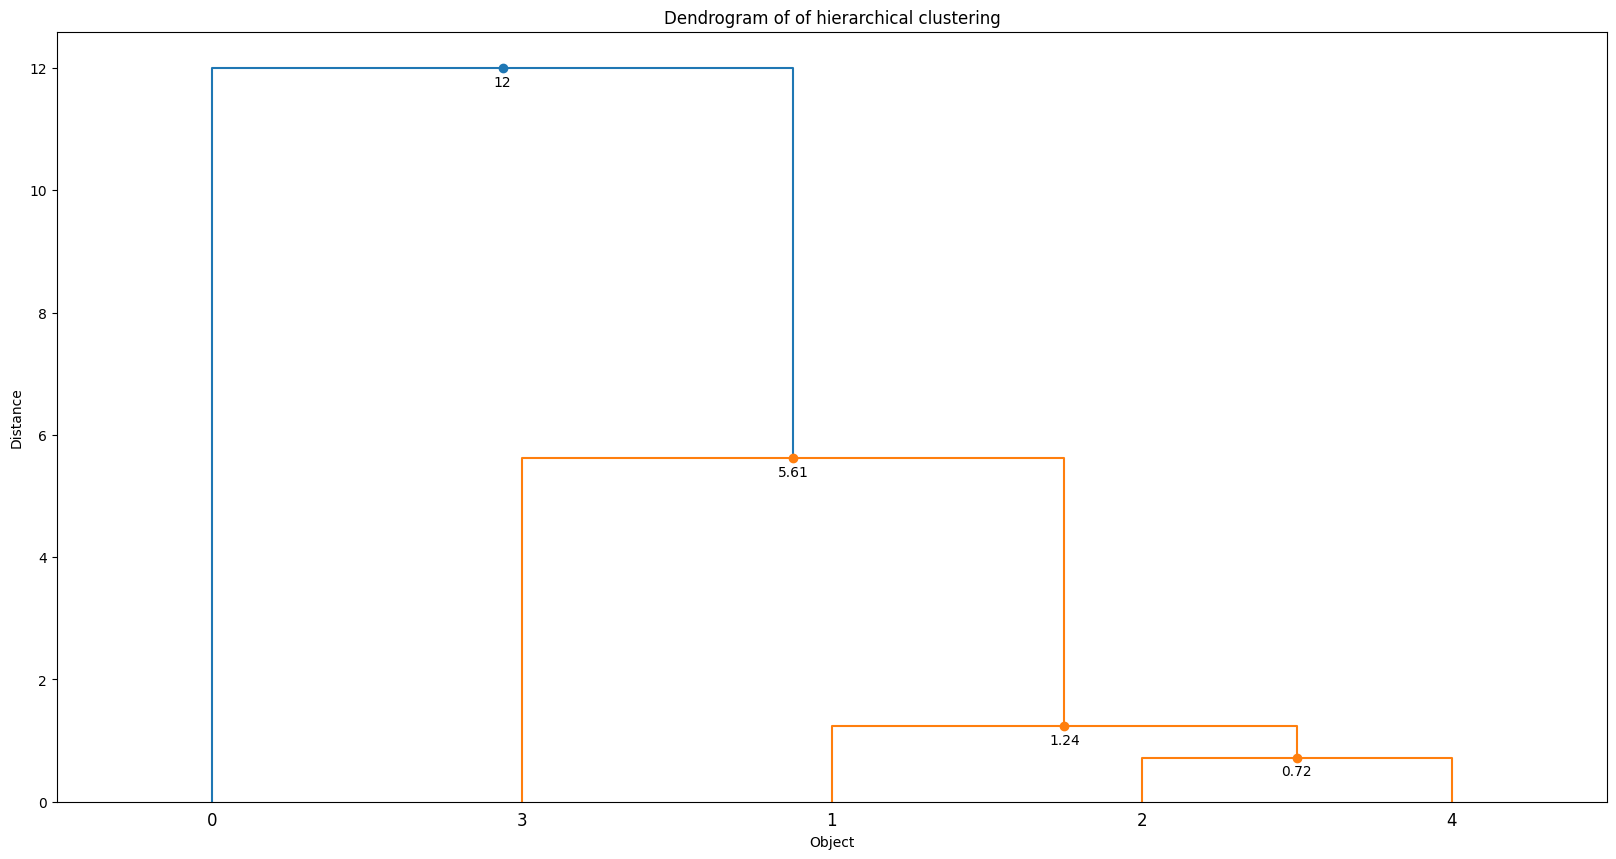

In [262]:
Z = linkage(data, method='average', metric='euclidean')
plt.figure(figsize=(20,10))
fancy_dendrogram(Z, 
    show_contracted=True);
plt.title("Dendrogram of of hierarchical clustering")
plt.xlabel("Object")
plt.ylabel("Distance")
plt.show()

In [263]:
features['cluster'] = fcluster(Z, t=5, criterion='distance')
features.sort_values('cluster')

0      1      2      3      4      5      6      7      8      9  ...  \
1   20.0   21.0   15.0   19.0   22.0   20.0   25.0   26.0   20.0   18.0  ...   
2   28.0   17.0   39.0   32.0   10.0    3.0    7.0    5.0   20.0   25.0  ...   
4    2.6    2.7    2.0    2.6    3.7    1.4    1.5    5.9    2.6    2.3  ...   
3    9.0    9.0    7.0    9.0   17.0    8.0   12.0   14.0    9.0    9.0  ...   
0  340.0  245.0  420.0  375.0  180.0  115.0  170.0  160.0  265.0  300.0  ...   

      19     20     21     22     23     24     25     26     name  cluster  
1   16.0   19.0   16.0   16.0   17.0   22.0   25.0   23.0  protein        1  
2    5.0   13.0    9.0   11.0    5.0    9.0    7.0    1.0     fats        1  
4    0.5    1.0    1.8    1.3    0.7    2.5    1.2    2.6     iron        1  
3   15.0    5.0  157.0   14.0  159.0  367.0    7.0   98.0  calcium        2  
0  135.0  200.0  155.0  195.0  120.0  180.0  170.0  110.0     cals        3  

[5 rows x 29 columns]